In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device: {device}")
torch.set_default_device(device)

device: mps


In [4]:
from module.conf import PROJECT_DIR
import struct
from array import array 

mnist_path = "/data/sample/mnist"
training_images_filepath = "".join([PROJECT_DIR, mnist_path, "/train-images.idx3-ubyte"])
training_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/train-labels.idx1-ubyte"])
test_images_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-images.idx3-ubyte"])
test_labels_filepath = "".join([PROJECT_DIR, mnist_path, "/t10k-labels.idx1-ubyte"])

def read_images_labels(images_filepath, labels_filepath) -> tuple:
    labels = []
    with open(labels_filepath, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        # labels = array("B", file.read())
        labels = array("B", file.read())

    with open(images_filepath, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        image_data = array("B", file.read())

    images = []
    # for i in range(size):
    #     images.append([0] * rows * cols)
    for i in range(size):
        img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
        img = img.reshape(28, 28)
        # images[i][:] = img
        images.append(img)

    return images, labels

def load_data() -> ((np.ndarray, np.ndarray),(np.ndarray, np.ndarray)):
    x_train, y_train = read_images_labels(training_images_filepath, training_labels_filepath)
    x_test, y_test = read_images_labels(test_images_filepath, test_labels_filepath)
    return (np.array(x_train, dtype=np.float32), np.array(y_train)),(np.array(x_test, dtype=np.float32), np.array(y_test))

(X_train, y_train), (X_test, y_test) = load_data()
# X_train, X_test = X_train / 255.0, X_test / 255.0

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_dim=784):  # 28*28=784 fors MNIST
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self, img_dim=784):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x)

In [6]:
# random noise vector
noise_dim = 100

# init Generator and Discriminator
gen = Generator(noise_dim).to(device=device)
disc = Discriminator().to(device=device)

# loss and optimizers
criterion = nn.BCELoss().to(device=device)
optimizer_gen = optim.Adam(gen.parameters(), lr=0.0002)
optimizer_disc = optim.Adam(disc.parameters(), lr=0.0002)

In [7]:
from torch.utils.data import Dataset


class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.tensor_dataset = tensor_dataset
        self.transform = transform
    def __len__(self):
        return len(self.tensor_dataset)
    def __getitem__(self, idx):
        sample, label = self.tensor_dataset[idx]
        if self.transform:
            sample = self.transform(sample)
            pass
        return sample, label

In [27]:
from torchvision.transforms import v2
transform = v2.Compose([
    # v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))  # Normalization to [-1, 1]
])

# dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=False)
train, test = torch.from_numpy(X_train).float()/127.5 - 1, torch.from_numpy(y_train).int()
# dataloader = DataLoader((train, test), batch_size=64, shuffle=True, generator=torch.Generator(device=device))
dataset = torch.utils.data.TensorDataset(train, test)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, generator=torch.Generator(device=device))
# dataloader = TransformedTensorDataset(dataset, transform=transform)

In [29]:
num_epochs = 10 #50
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        batch_size = real.size(0)   # batch_size
        real: torch.Tensor = real.view(batch_size, -1).to(device=device)    # reshape
        
        # Labels for real and fake
        labels_real = torch.ones(batch_size, 1).to(device=device)
        labels_fake = torch.zeros(batch_size, 1).to(device=device)

        # train Discriminator for real
        disc_real = disc(real)
        loss_disc_real = criterion(disc_real, labels_real)

        # train Discriminator for fake
        noise = torch.randn(batch_size, noise_dim)
        fake_images = gen(noise)
        disc_fake = disc(fake_images.detach())
        loss_disc_fake = criterion(disc_fake, labels_fake)

        # total loss of Discriminator
        loss_disc: torch.Tensor = (loss_disc_real + loss_disc_fake) / 2
        optimizer_disc.zero_grad()
        loss_disc.backward()
        optimizer_disc.step()

        # train Generator to fool Discriminator
        output = disc(fake_images)
        loss_gen = criterion(output, labels_real)
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")

Epoch [1/10] | Loss D: 0.4132, Loss G: 2.0428
Epoch [2/10] | Loss D: 0.2971, Loss G: 1.5478
Epoch [3/10] | Loss D: 0.4221, Loss G: 2.2056
Epoch [4/10] | Loss D: 0.4298, Loss G: 1.8214
Epoch [5/10] | Loss D: 0.5227, Loss G: 1.0401
Epoch [6/10] | Loss D: 0.4775, Loss G: 1.7065
Epoch [7/10] | Loss D: 0.4609, Loss G: 1.4400
Epoch [8/10] | Loss D: 0.5563, Loss G: 1.2151
Epoch [9/10] | Loss D: 0.5441, Loss G: 1.2382
Epoch [10/10] | Loss D: 0.5794, Loss G: 1.2732


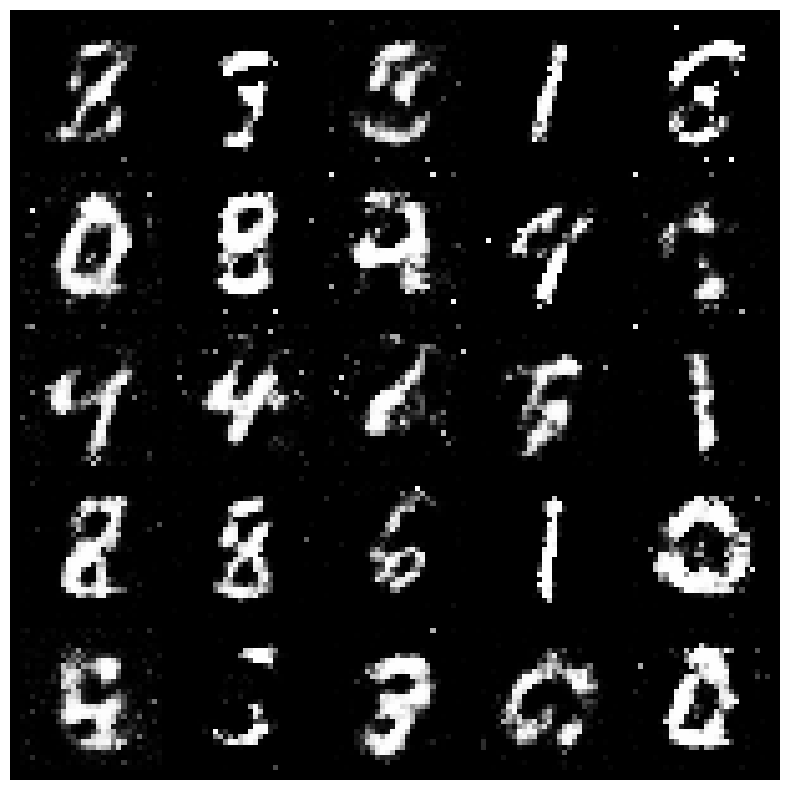

In [30]:
def generate_and_plot_images(generator, noise_dim, num_images=25):
    noise = torch.randn(num_images, noise_dim)
    fake_images = generator(noise).view(-1, 1, 28, 28)
    fake_images = (fake_images ) / 2 + 0.5 # scale to [0, 1]

    grid = torchvision.utils.make_grid(fake_images, nrow=5)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

# generate
generate_and_plot_images(gen, noise_dim)